# Optimal control of moving masses

The objective of this notebook it is to introduce you to linear optimal control theory! This material will serve a foundation for understanding how Model Predictive Control (MPC) is implemented based on som fundamental concepts you will learn have the chance to learn in this notes.


We start by considering the system in the figure below, consisting of six unit masses connected by springs to each other, and to walls on either side. There are three actuators, which exert tensions between certain pairs of masses. Its dynamics can be described by


<center><img src="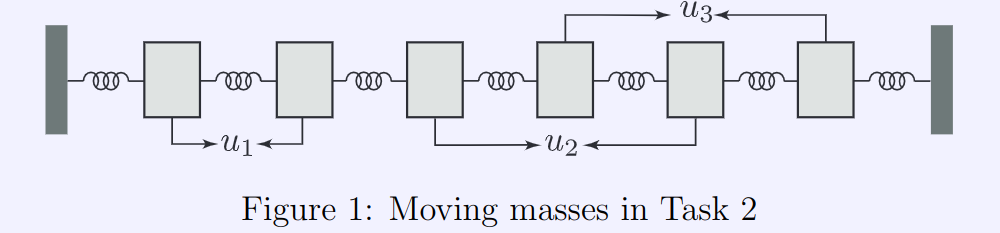"/></center>


$$
\begin{align}
\dot{x}(t) &= \begin{pmatrix}
    0& I \\
    A_{21}& 0
\end{pmatrix}x(t) +
\begin{pmatrix}
    0 \\ B_2
\end{pmatrix}u(t), \qquad y(t)=\begin{pmatrix}
    I & 0 
\end{pmatrix}x(t)
\end{align}
$$
where
$$
\begin{align}
    A_{21} &=
    \begin{pmatrix}
        -2 & 1&0 &0 & 0 & 0\\
        1 & -2 & 1 & 0 & 0 & 0\\
        0 & 1 & -2 & 1 & 0 & 0\\
        0 & 0 & 1 & -2 & 1 & 0\\
        0 & 0 & 0 & 1 & -2 & 1\\
        0 & 0 & 0 & 0 & 1 & -2\\
    \end{pmatrix}, \; 
    B_2=
    \begin{pmatrix}
        1 & 0 & 0\\
        -1 & 0 & 0\\
        0 & 1 & 0\\
        0 & 0 & 1\\
        0 & -1 & 0\\
        0 & 0 & -1
    \end{pmatrix}
\end{align}
$$

The first six states are the velocities of the masses, and the last states are their displacements from their equilibrium positions. The actuators can exert a maximum force of $\pm 0.5$, and the displacements of the masses cannot exceed $\pm 4$. We will now define this system in python and answer some questions. First let's import some packages!

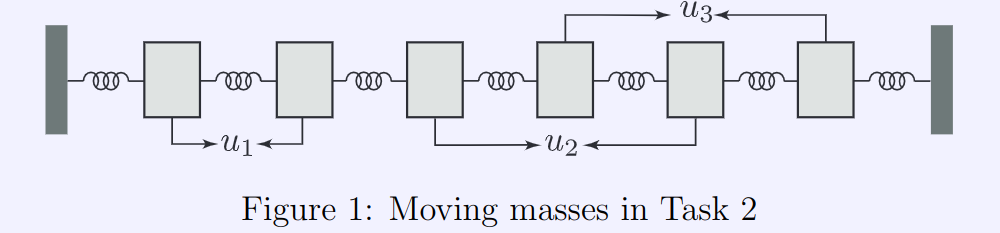

In [29]:
import numpy as np
import cvxpy as cp
import control as ctrl
import matplotlib.pyplot as plt

Now let's define the system matrices for the hanging chain example above.

In [30]:
# Define system matrices

A21 = np.array([
    [-2,  1,  0,  0,  0,  0],
    [ 1, -2,  1,  0,  0,  0],
    [ 0,  1, -2,  1,  0,  0],
    [ 0,  0,  1, -2,  1,  0],
    [ 0,  0,  0,  1, -2,  1],
    [ 0,  0,  0,  0,  1, -2]
])

# Define B2 matrix
B2 = np.array([
    [ 1,  0,  0],
    [-1,  0,  0],
    [ 0,  1,  0],
    [ 0,  0,  1],
    [ 0, -1,  0],
    [ 0,  0, -1]
])

# Extract number of masses and number of controls
num_masses, num_controls = B2.shape
print(f"no masses: {num_masses} || no controls:{num_controls}")

# Create I (identity matrix) with the size of num_masses
I = np.eye(num_masses)

# Create the system matrices A, B, and C using num_masses and num_controls
Ac = np.block([
    [np.zeros((num_masses, num_masses)), I],
    [A21, np.zeros((num_masses, num_masses))]
])
Bc = np.vstack([np.zeros((num_masses, num_controls)), B2])
Cc = np.hstack([I, np.zeros((num_masses, num_masses))])
Dc = np.zeros([6,3])
# Print the resulting matrices
#print("A matrix:\n", Ac)
#print("\nB matrix:\n", Bc)
#print("\nC matrix:\n", Cc)
#print(Cc.shape)

no masses: 6 || no controls:3


Q(a) : Use the numpy and control packages to define matrices Ac, Bc and Cc, along with a state-space system object to find the discrete time matrices of the system with a sampling time of $h=0.5$

In [31]:
# Create the continuous-time state-space system
sysc = ctrl.ss(Ac,Bc,Cc,Dc) #! todo: fill in the system matrices


# Convert the system to discrete time with a sampling interval h = 0.5 seconds
h = 0.5
sys_discrete = ctrl.c2d(sysc,h)  #! todo: convert state to sample data

A = sys_discrete.A
B = sys_discrete.B
C = sys_discrete.C
D = sys_discrete.D


Now that the system dynamics is discretized we can start playing with some optimal control!

Q(b) Pose the problem of minimizing the energy required to transfer the masses from  $x_0=\begin{pmatrix} 0_{6\times 1}, & 2\cdot \mathbf{1}_{6\times 1} \end{pmatrix}$ to $x_T=0_{12\times 0}$ as an optimal control problem on the standard form. Solve the problem using `cvxpy`. Plot the state trajectories and the optimal input against time. 

What is the minimum energy $\sum_{t=0}^{T-1}\Vert u_t\Vert_2^2$ required for the state-transfer?


In [32]:
T = 100  # Number of steps

# Define the state and control variables over time
#! todo: create system state and control variables
x = cp.Variable((2*num_masses, T+1))
u = cp.Variable((num_controls, T))


# Initial and target states
xT = np.zeros((2*num_masses, 1)) #questo è lo stato finale, easy
x0 = np.vstack([2 * np.ones((num_masses, 1)), np.zeros((num_masses, 1))]) # in pratica qua dice che le posizioni sono =1, le velocità = 0

energy = 0
for i in range(T):
    energy+= u[:,i].T@u[:,i]
    
objective = cp.Minimize(energy)


In [33]:

# Constraints
constraints = []

# Initial state constraint
constraints.append(x[:, 0] == x0.flatten())

# Dynamics and control constraints
for t in range(T):
    constraints.append(x[:, t+1] == A @ x[:, t] + B @ u[:, t])
    constraints.append(u[:, t] <= 0.5)
    constraints.append(u[:, t] >= -0.5)

    # Displacement constraints on the output y=C@x
    #! todo: fill output constraints
    constraints.append(...)
    constraints.append(...)

# Final state constraint
constraints.append(x[:, T] == xT.flatten())

# Formulate and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Print the optimal value and control inputs
print("Optimal energy:", problem.value)
print("Optimal control inputs:\n", u.value)


ValueError: Problem has an invalid constraint of type <class 'ellipsis'>

We now plot the optimal solution

In [ ]:

# Extract the optimal values
x_opt = x.value
u_opt = u.value

# Calculate y = C @ x for all time steps
y_opt = C @ x_opt

# Time vector
time = np.arange(T+1) * h

# Create the 2-by-1 plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Upper plot: Output y=C@x over time with constraints
for i in range(num_masses):
    ax1.plot(time, y_opt[i, :], label=f'Mass {i+1}')

ax1.axhline(4, color='r', linestyle='--', label='Upper displacement constraint')
ax1.axhline(-4, color='r', linestyle='--', label='Lower displacement constraint')
ax1.set_xlim([0, T*h])
ax1.set_ylabel('Displacement (y = C @ x)')
ax1.set_title('Displacement of Masses Over Time')
ax1.legend(loc='upper right')
ax1.grid(True)

# Lower plot: Control signals over time with constraints
for i in range(num_controls):
    ax2.plot(time[:-1], u_opt[i, :], label=f'Control {i+1}')

ax2.axhline(0.5, color='r', linestyle='--', label='Upper control constraint')
ax2.axhline(-0.5, color='r', linestyle='--', label='Lower control constraint')
ax2.set_xlim([0, T*h])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Control Inputs')
ax2.set_title('Control Inputs Over Time')
ax2.legend(loc='upper right')
ax2.grid(True)

NameError: name 'x' is not defined

Q(c) Plot the minimal input energy against horizon length for $T\in [30, \dots, 100]$. For readability, transform your code in (b) into a function `(u_opt, x_opt)=openLoopOptimalControl(A,B,C,ulim,ylim,T,x0,xT)` that returns the optimal control and state trajectories. Loop over $T$, compute the optimal input sequences, determine their energy cost, and plot the result.

In [ ]:
def openLoopOptimalControl(A, B, C, ulim, ylim, T, x0, xT):
    """ Solve the open-loop optimal control problem for a given horizon T. """
    
    #! todo: copy the code form the cells before to wrap it into a function

    # Return the optimal control trajectory and state trajectory
    return u.value, x.value


# System dimensions
num_masses = 6
num_controls = 3
h = 0.5  # Sampling time

# Assume Ad, Bd, Cd, Dd are already defined as above

# Initial and target states
x0 = np.vstack([2 * np.ones((num_masses, 1)), np.zeros((num_masses, 1))])
xT = np.zeros((2*num_masses, 1))

# Control and displacement constraints
ulim = 0.5
ylim = 4

# Horizon length sweep parameters
Tmin = 30
Tmax = 100
energy_costs = []

# Sweep over different horizon lengths
for T in range(Tmin, Tmax + 1):
    (u_opt, x_opt) = openLoopOptimalControl(A, B, C, ulim, ylim, T, x0, xT)
    total_energy = np.sum(np.square(u_opt))  # Compute total energy cost
    energy_costs.append(total_energy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(Tmin, Tmax + 1), energy_costs, marker='o')
plt.xlabel('Horizon Length (T)')
plt.ylabel('Total Energy Cost')
plt.title('Total Energy Cost vs Horizon Length')
plt.grid(True)
plt.show()


After some testing we realize that the lowest possible time that can be used to solve the problem is 25s. Run the following cell to see what is the solution of the optimal control problem in this case!

In [ ]:
# Shortest horizon that can be used
T = 25

# Call the openLoopOptimalControl function with T=25
u_opt, x_opt = openLoopOptimalControl(A, B, C, ulim, ylim, T, x0, xT)

# Calculate y = C @ x for all time steps
y_opt = C @ x_opt

# Time vector
time = np.arange(T+1) * h

# Create the 2-by-1 plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Upper plot: Output y=C@x over time with constraints
for i in range(num_masses):
    ax1.plot(time, y_opt[i, :], label=f'Mass {i+1}')

ax1.axhline(4, color='r', linestyle='--', label='Upper displacement constraint')
ax1.axhline(-4, color='r', linestyle='--', label='Lower displacement constraint')
ax1.set_ylabel('Displacement (y = C @ x)')
ax1.set_title('Displacement of Masses Over Time')
ax1.set_xlim([0, T*h])
ax1.legend(loc='upper right')
ax1.grid(True)

# Lower plot: Control signals over time with constraints
for i in range(num_controls):
    ax2.plot(time[:-1], u_opt[i, :], label=f'Control {i+1}')

ax2.axhline(0.5, color='r', linestyle='--', label='Upper control constraint')
ax2.axhline(-0.5, color='r', linestyle='--', label='Lower control constraint')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Control Inputs')
ax2.set_title('Control Inputs Over Time')
ax2.set_xlim([0, T*h])
ax2.legend(loc='upper right')
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Highlights 

If you arrived till here, well done! From this notebook you should have learned how to solve an open loop optimal control problem for a linear system with input and output saturation. Indeed you coded such open loop optimal control problem  in the function `openLoopOptimalControl(A, B, C, ulim, ylim, T, x0, xT)` where `A`,`B` and `C` are your dynamics matrices,  `ulim`, `ylim` are your input and output saturations and `x0`, `xT` and `T` are initial state, target state and the number of steps `T` to achieve the transfer from `x0` to `xT`. 

The reason why this function is called `openLoop` is due to a control theory terminology. Namely, we call a sequence of control inputs `u = [u_0,u_1,u_2,...]` an open loop input when we compute the sequence `u` only once at the initial time and then we feed the input to the system as it is. So after time `0` we do not use any state-feedback information from the system to update our control input sequence. If we instead use state information to update our control sequence online, what we obtain is a closed loop input sequence `u`, which will be topic of the future computer exercises.


While we will analyze the advantages of using the power of feedback in our control solutions, you should recall that the optimal control sequence you found by calling the function `openLoopOptimalControl(A, B, C, ulim, ylim, T, x0, xT)` assumes that you have a perfect model of the system and that the system is not subject to any disturbances. What do you think it will then happen if you feed your optimal control input to the system in a real world scenario where all sort of mathematical assumptions are gone? Will you exactly drive the system from start to final state? Will your system excatly respect all the constraints under your optimal input sequence?

These and other questions will be clarified iun the next exercise session!







